# Ground temperature history inversion

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
from heat import heat
import pickle
from tqdm import tqdm
import multiprocessing as mp

# Load the real data

In [3]:
filepath = '/data/fast1/jm-scratch/data_proc.pkl'

with open(filepath,'rb') as file:
    data = pickle.load(file)
real_data = data['ALHIC1902_23_5min']

z_full = np.array(real_data[0])
z_real = z_full[::10]
T_full = np.array(real_data[2])
T_real = T_full[::10]

max_depth = max(z_real)
nz = len(z_real)
print(f'max_depth={max_depth}')
print(f'nz={nz}')
# T = real_data[1].values
# T.shape

max_depth=205.93200000000002
nz=82


/home/bpl7/.conda/envs/python3.11-obspy/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/home/bpl7/.conda/envs/python3.11-obspy/lib/python3.11/site-packages/dask/array/numpy_compat.py:53: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


# Generate the data kernel matrix, G
Note that we solve for the perturbation that deviates for a steady state solution with constant surface temperature and constant basal heat flux.  

In [65]:
# Define a steady state model
tsurf_avg=-32.1
dTdz = 0.02

def steadystate(z):
    return tsurf_avg+dTdz*z

data_minus_stead_state = T_real - steadystate(z_real)

In [23]:
start_year = 1923
end_year = 2023
number_of_time_steps = 399
# t = np.linspace(start_year,end_year, number_of_time_steps+1)
t = np.linspace(0,end_year-start_year, number_of_time_steps+1)

In [24]:
# Function to organize the Greens Function
def get_G(T,t):
    # T is the period of oscillation
    modal =  np.sin(2*np.pi * t / T)

    U,t,z = heat(modal,tmax=end_year,tmin=start_year,nt=number_of_time_steps,zmax=max_depth,
            dTdz=dTdz,nz=(nz-1))
    return U[:,-1]

def get_G2(T,t):
    # T is the period of oscillation
    modal =  np.cos(2*np.pi * t / T)

    U,t,z = heat(modal,tmax=end_year,tmin=start_year,nt=number_of_time_steps,zmax=max_depth,
            dTdz=dTdz,nz=(nz-1))
    return U[:,-1]

# Run 1: 100 year time scale

In [93]:
number_of_periods = end_year - start_year
period_list = range(number_of_periods)[1:]
number_of_periods = number_of_periods - 1
# period_list = np.
# number_of_periods = len(period_list)

G1 = np.zeros((nz,number_of_periods))
for i,T in tqdm(enumerate(period_list)): 
    G1[:,i] = get_G(T,t) #- steadystate(z_real)

G2 = np.zeros((nz,number_of_periods))
for i,T in tqdm(enumerate(period_list)): 
    G2[:,i] = get_G2(T,t) #- steadystate(z_real)

99it [00:34,  2.87it/s]
99it [00:34,  2.87it/s]


In [94]:
G = np.hstack((G1,G2))

(205.93200000000002, 0.03100000000000591)

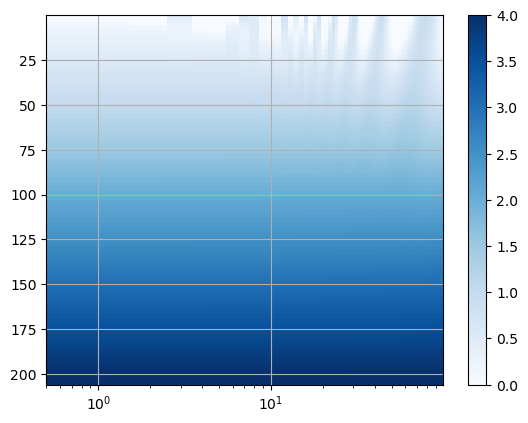

In [95]:
c=plt.pcolormesh(period_list,z_real,G1,vmin=0,vmax=4,cmap='Blues')
plt.colorbar(c)
plt.xscale('log')
plt.grid()
plt.ylim([z_real[-1],z_real[0]])

# Inversion with Real Data

9.999999999999999e-06
0.001
0.09999999999999999


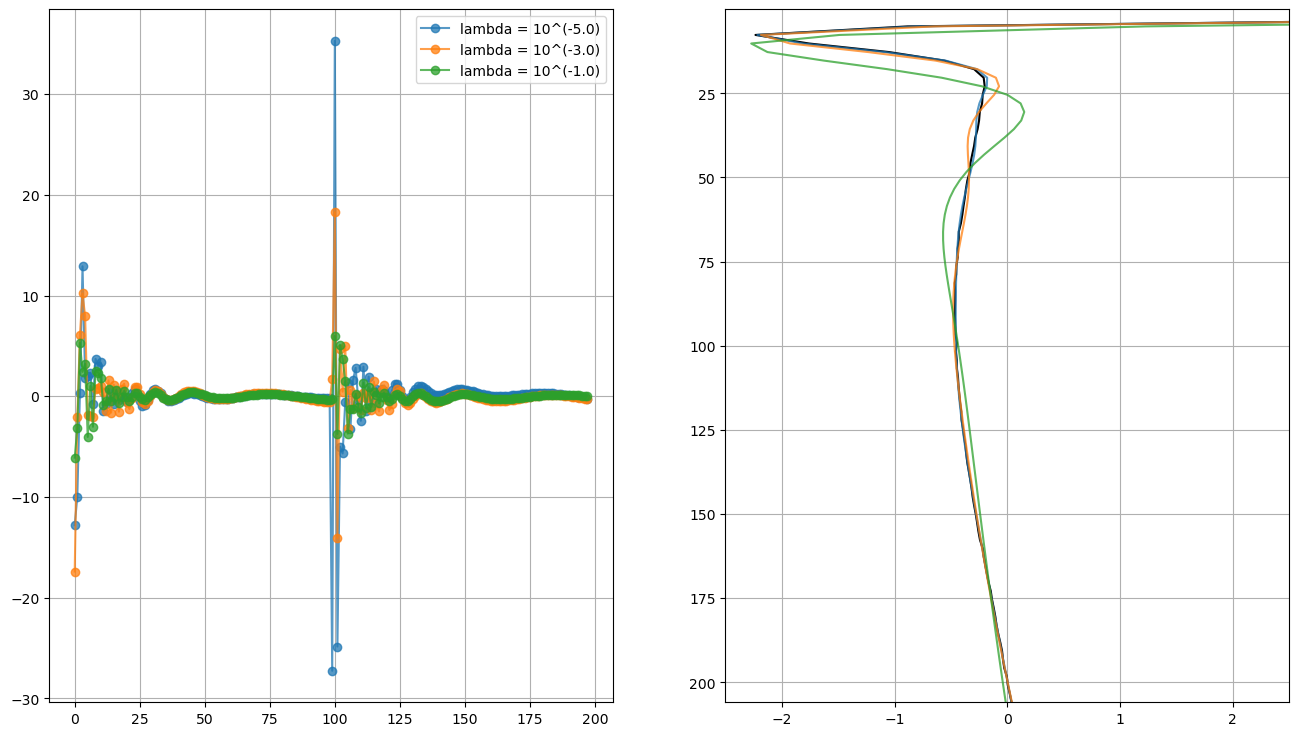

In [100]:
fig,ax=plt.subplots(1,2,figsize=(16,9))
ax[1].plot(data_minus_stead_state,z_real,'-k')
for lmbda in np.logspace(-5,-1,3): # Damping parameter (regularization parameter)
    print(lmbda)
    # Formulate the regularized least squares problem
    # We need to augment A with the regularization term
    A_augmented = np.vstack([G, np.sqrt(lmbda) * np.eye(G.shape[1])])
    b_augmented = np.concatenate([data_minus_stead_state, np.zeros(G.shape[1])])

    # Solve the regularized least squares problem
    x_damped, residuals, rank, singular_values = np.linalg.lstsq(A_augmented, b_augmented, rcond=None)
    ax[0].plot(x_damped,'-o',
               label=f'lambda = 10^({np.log10(lmbda)})',alpha=0.75)

    T_fit = np.matmul(G,x_damped)
    ax[1].plot(T_fit,z_real,alpha=0.75)


ax[1].set_ylim([z_real[-1],z_real[0]])
ax[1].set_xlim([-2.5,2.5])
ax[0].grid()
ax[1].grid()
# ax[0].set_xlim([2010,2025])
ax[0].legend()

# plt.plot(t[1:-1],synthetic_history,'--k')